In [1]:
from spacepy import pycdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cdf = pycdf.CDF("example_data/thg_l1_asf_rank_2008021005_v01.cdf")
cdf_dat = cdf.copy()

In [3]:
# asf -> all sky full
cdf.attrs

<gAttrList:
ADID_ref: NSSD0110 [CDF_CHAR]
Acknowledgement: NASA Contract NAS5-02099 [CDF_CHAR]
Data_type: ASF>All Sky Imager, Full resolution images, High resolution [CDF_CHAR]
Data_version: 1 [CDF_CHAR]
Descriptor: RANK>Rankin Inlet Canada [CDF_CHAR]
Discipline: Space Physics>Magnetospheric Science [CDF_CHAR]
            Space Physics>Ionospheric Science [CDF_CHAR]
File_naming_convention: source_datatype_descriptor [CDF_CHAR]
Generated_by: Harald Frey [CDF_CHAR]
Generation_date: 2006-10-24 [CDF_CHAR]
HTTP_LINK: http://sprg.ssl.berkeley.edu/themis [CDF_CHAR]
           http://aurora.phys.ucalgary.ca/themis [CDF_CHAR]
Instrument_type: Ground-Based VLF/ELF/ULF, Photometrics [CDF_CHAR]
LINK_TEXT: http://sprg.ssl.berkeley.edu/themis [CDF_CHAR]
           http://aurora.phys.ucalgary.ca/themis [CDF_CHAR]
LINK_TITLE: THEMIS GBO portal [CDF_CHAR]
            THEMIS-Canada portal [CDF_CHAR]
Logical_file_id: thg_l1_asf_rank_2008021005_v01 [CDF_CHAR]
Logical_source: thg_l1_asf_rank [CDF_CHAR]
Log

In [4]:
print(cdf)

range_epoch: CDF_EPOCH [2]
thg_asf_rank: CDF_UINT2 [1200, 256, 256]
thg_asf_rank_column: CDF_UINT2 [256] NRV
thg_asf_rank_epoch: CDF_EPOCH [1200]
thg_asf_rank_epoch0: CDF_EPOCH [] NRV
thg_asf_rank_row: CDF_UINT2 [256] NRV
thg_asf_rank_tend: CDF_REAL8 [1200]
thg_asf_rank_time: CDF_REAL8 [1200]


In [94]:
cdf_dat['thg_asf_rank_epoch'][2].strftime("%B %d, %Y %H:%M:%S")

'February 10, 2008 05:00:06'

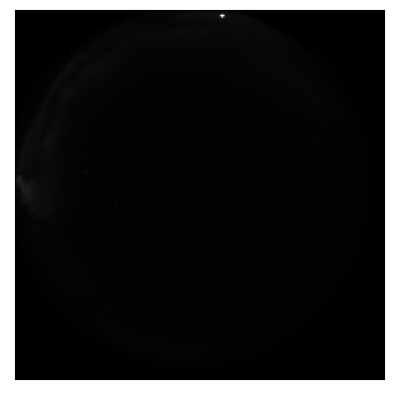

In [222]:
images = np.array(cdf_dat['thg_asf_rank'])
plt.imshow(images[1100], cmap='gray')
plt.xticks(())
plt.yticks(());

In [6]:
def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

images_cropped = np.array([crop_img(image, .85) for image in images])
images_cropped.shape

(1200, 217, 217)

In [158]:
def process_images(images):
    processed_images = []
    for image in images:
        processed_image = image - np.percentile(image, 1)
        processed_image = processed_image / np.percentile(image, 99)
        processed_image = np.maximum(np.zeros(processed_image.shape), processed_image)
        processed_image = np.minimum(np.ones(processed_image.shape), processed_image)
        processed_images.append(processed_image)
    return np.array(processed_images)

images_processed = process_images(images)

In [161]:
def show_image(image, h=256, w= 256):
    "Helper function to plot a single image."
    plt.imshow(image, cmap='gray') 
    plt.xticks(())
    plt.yticks(())

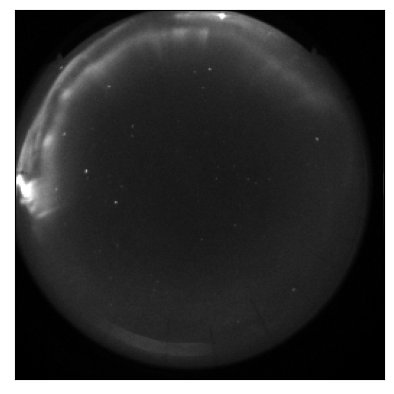

In [162]:
show_image(images_processed[1100])

In [165]:
def show_images(images, titles=None, n_row=4, n_col=5, h=256, w=256): 
    """Helper function to plot a gallery of images""" 
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row)) 
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35) 
    if titles is None:
        titles = ["" for _ in images]
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i + 1) 
        image = images[i]
        plt.imshow(image, cmap='gray') 
        plt.title(titles[i], size=12) 
        plt.xticks(())
        plt.yticks(())

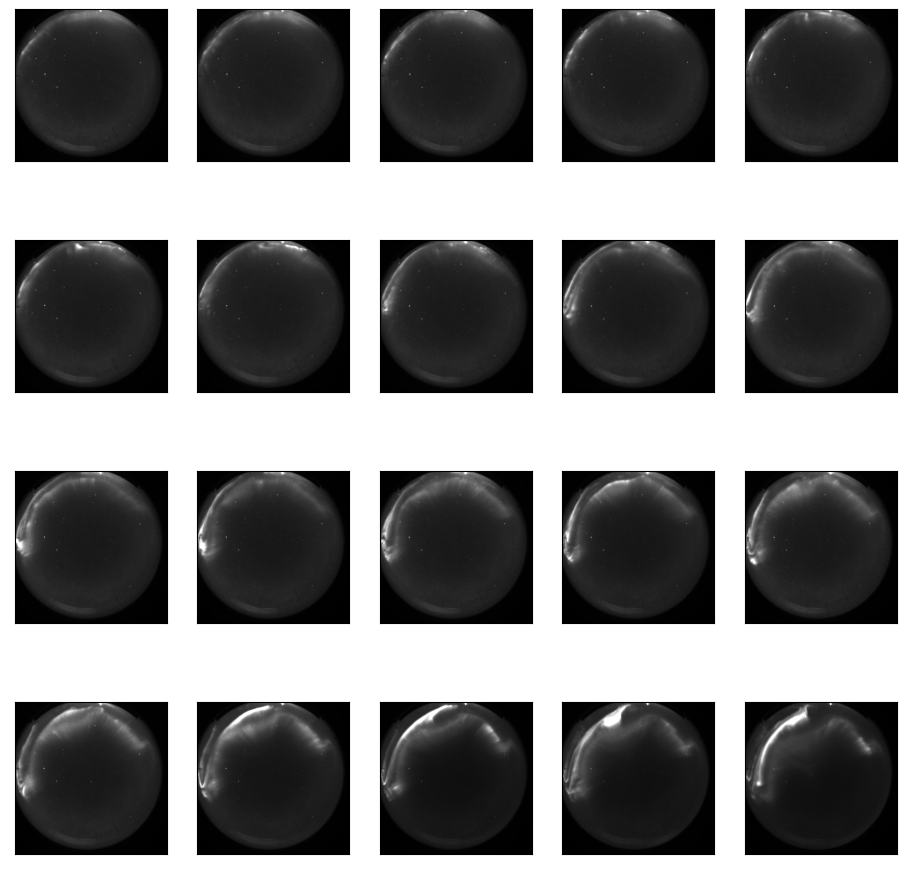

In [166]:
show_images(images_processed[1000:1200:10])

# PCA

In [167]:
# principal components represent the directions of the data that explain a maximal amount of variance, 
# that is to say, the lines that capture most information of the data
from sklearn.decomposition import PCA

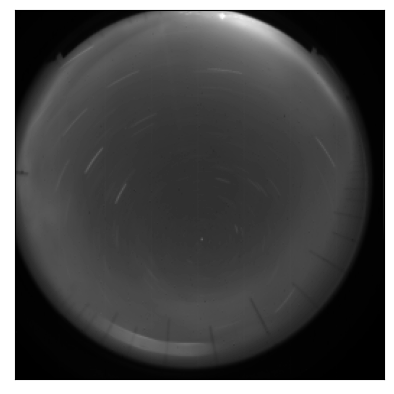

In [168]:
def center_data(X):
    X_mean = np.mean(X, axis=0)
    sub_matrix = np.array([X_mean for i in range(len(X))]) 
    X_center = X - sub_matrix
    return X_center, X_mean

X = images_processed
X, X_mean = center_data(images_processed)
show_image(X_mean)

In [169]:
nsamples, nx, ny = X.shape
d2_images_processed = X.reshape((nsamples,nx*ny))
pca = PCA(4)
converted_data = pca.fit_transform(d2_images_processed)
converted_data.shape

(1200, 4)

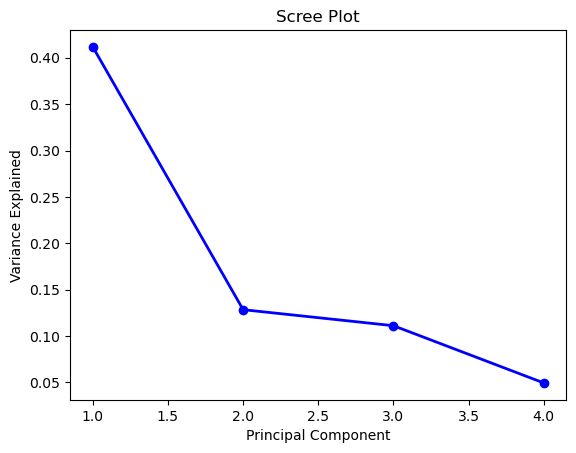

In [170]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

array([[-2.44269078, -1.59797088,  1.50079426, -2.1979049 ],
       [-2.51023556, -1.72021135,  1.64031088, -2.28880139],
       [-2.57531523, -1.86475359,  1.85251014, -2.44628659],
       ...,
       [23.11799326, 12.71004478,  6.01209172, -1.04397073],
       [22.82140683, 12.80214052,  6.18721147, -0.85938341],
       [22.8630108 , 12.93676839,  6.13407817, -0.57603439]])

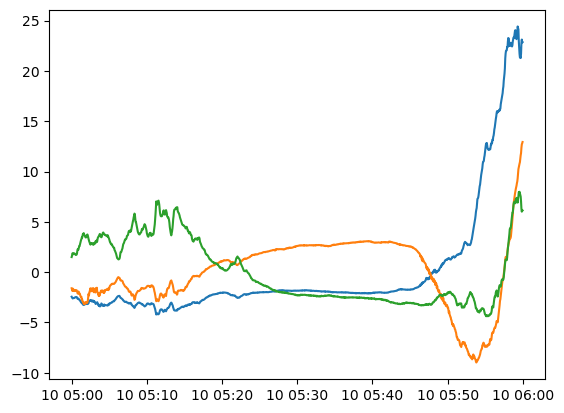

In [171]:
plt.plot(np.array(cdf_dat['thg_asf_rank_epoch']), [(x[0], x[1], x[2]) for x in converted_data])
converted_data

# Classification

In [172]:
from PIL import Image
import PIL

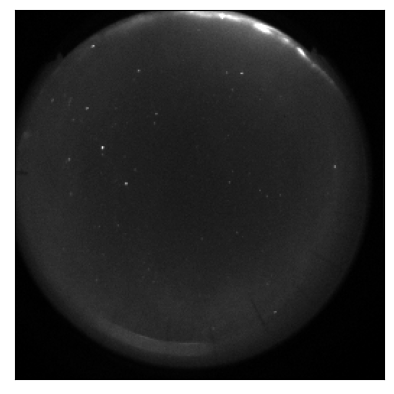

In [180]:
plt.imshow(images_processed[0], cmap='gray')
plt.xticks(())
plt.yticks(());

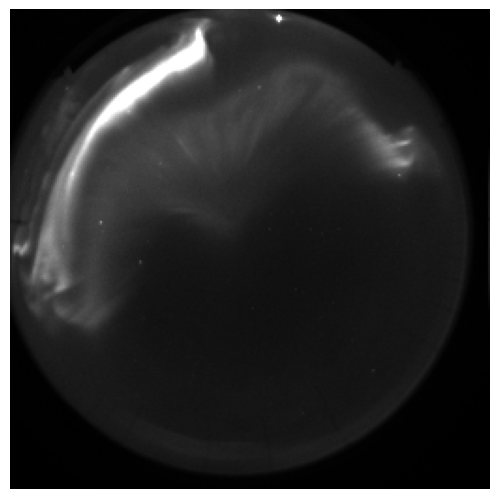

In [184]:
for i, pixels in enumerate(images_processed[0::5]):
    plt.imshow(pixels, cmap='gray') 
    plt.xticks(())
    plt.yticks(())
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('./example_data/rank_asf_2010021005_images/'+str(i*5)+'.png', bbox_inches='tight', pad_inches=0.0)

In [186]:
import glob
import sys 
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/dataHandler"))
from dataHandler import AsimClassifier
from PIL import Image
torch_data_location = "/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/data/torch/"
clf = AsimClassifier(torch_path=torch_data_location)

In [187]:
image_files = glob.glob("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/example_data/rank_asf_2010021005_images/*.png")

In [188]:
results = clf.classify_images(image_files)

2022-10-14 14:57:43,986 - logger - INFO - Device set to cpu
2022-10-14 14:57:43,986 - logger - INFO - loading pretrained torchvision model
/Users/jeffreysung/mambaforge/envs/substorm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jeffreysung/mambaforge/envs/substorm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2022-10-14 14:57:44,036 - logger - INFO - Extracting features


 |==================================================| 100.000% 


In [189]:
results

,file,pred,class_0,class_1,class_2,class_3,class_4,class_5,feat_0,feat_1,...,feat_990,feat_991,feat_992,feat_993,feat_994,feat_995,feat_996,feat_997,feat_998,feat_999
0,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.519906,0.379052,0.007236,0.001967,0.000632,0.091207,-0.466591,1.809839,...,-2.211347,0.714478,0.747620,2.315432,1.748288,-0.720330,-0.368852,2.285782,-1.973382,-1.155766
1,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.693856,0.178668,0.079704,0.006770,0.001808,0.039195,-0.354746,1.570361,...,-2.766837,0.567967,0.805125,0.823364,2.145325,-1.254791,-0.169769,1.936531,-2.041988,-1.883674
2,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,1,0.239871,0.461119,0.003301,0.007951,0.000154,0.287604,-0.613125,1.149742,...,-2.883402,1.645278,1.678283,2.126338,1.769741,-0.393208,-0.851387,2.676805,-1.709069,-2.163937
3,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.402694,0.092828,0.001552,0.003378,0.000128,0.499421,-0.915070,0.974416,...,-4.409861,1.840665,1.228827,2.371037,1.998179,-0.960995,-0.075008,2.969854,-2.150775,-3.002281
4,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.247893,0.129735,0.002058,0.010647,0.000108,0.609559,-1.214488,0.616454,...,-3.812536,1.906875,2.045009,2.241313,1.360370,-0.514268,-1.558964,2.742202,-2.644408,-1.974580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.413477,0.083468,0.005386,0.001158,0.000159,0.496351,-0.160363,1.179131,...,-1.881544,0.959481,0.648519,1.998717,2.041931,-0.700824,0.082912,2.390178,-2.095701,-1.572360
236,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.469515,0.170241,0.009673,0.003462,0.000836,0.346273,-0.719202,1.129904,...,-2.234379,0.752763,0.656366,1.982364,2.017172,-1.287668,-0.071712,2.282390,-1.482401,-1.386488
237,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.215902,0.270621,0.002506,0.005776,0.000079,0.505116,-1.019286,0.736894,...,-2.580903,1.731155,1.777702,2.012663,1.681795,-0.440975,-0.858314,2.855511,-2.039447,-1.941950
238,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,2,0.127328,0.028304,0.833181,0.001335,0.001587,0.008265,1.388264,1.780373,...,-1.815972,-1.611292,-1.742851,0.316313,2.798465,-1.179524,-0.815602,0.694929,-1.446402,-0.390384


In [202]:
# input integer between 0 and len(image_list) - 1
def display_single_result(image_list, results, index):
    im = Image.open(image_list[index])
    plt.imshow(im)
    plt.xticks(())
    plt.yticks(())
    class_probabilities = [str(results.iloc[index]["class_"+str(i)]*100) for i in range(6)]
    print("arc with probability " + class_probabilities[0] + "%")
    print("diffuse with probability " + class_probabilities[1] + "%")
    print("discrete with probability " + class_probabilities[2] + "%")
    print("cloud with probability " + class_probabilities[3] + "%")
    print("moon with probability " + class_probabilities[4] + "%")
    print("clear sky with probability " + class_probabilities[5] + "%")

arc with probability 12.732782000560716%
diffuse with probability 2.830422402528442%
discrete with probability 83.31808519992153%
cloud with probability 0.13354331834751423%
moon with probability 0.15870534965779617%
clear sky with probability 0.8264617289840487%


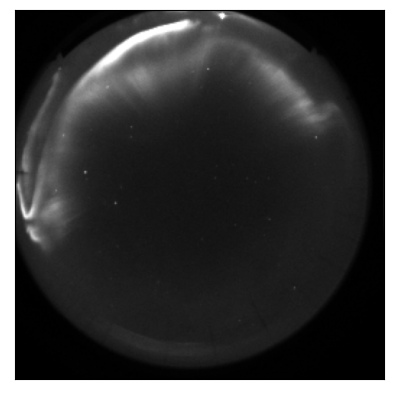

In [221]:
display_single_result(image_files, results, 238)

ValueError: x and y must have same first dimension, but have shapes (240,) and (1,)

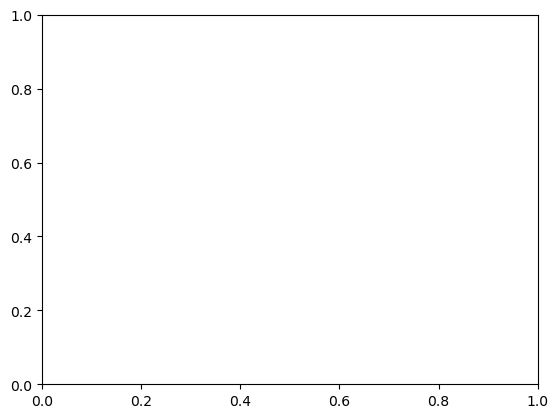

In [230]:
plt.plot(results['pred'], re)